<a href="https://colab.research.google.com/github/ynw99/ML-BangkitCapstone/blob/main/Capstone_Project_Batik_Pattern_Recognition_ResNet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun  1 23:22:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparing Dataset

## Extract Dataset
Start here.

In [ ]:
%%capture
!unzip "/content/drive/MyDrive/Dataset/dataset_batik.zip" -d "/content/dataset/"

## Delete Error Images

In [ ]:
%%capture
!rm "/content/dataset/Training/Ceplok/Yogya-Tulis-Prabu anom Truntum grompol Riningan-Truntum,Grompol-Sogan.jpg" "/content/dataset/Training/Parang/KP042.jpg" "/content/dataset/Training/Parang/KP044.jpg"  "/content/dataset/Training/Parang/Kudus-Parang-Parang,Flora-Non Sogan (1).jpg" "/content/dataset/Training/Parang/Kudus-Parang-Parang,Flora-Non Sogan (2).jpg"

# Data Preprocessing & Modelling

In [ ]:
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.applications import ResNet50V2
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
TRAINING_DIR = '/content/dataset/Training'
VALIDATION_DIR = '/content/dataset/Testing'

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 180
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 10
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 10
)

Found 580 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


In [ ]:
tf.keras.backend.clear_session()

# Pretrained model
feature_extractor =  ResNet50V2(include_top = False,
                           weights='imagenet',
                           input_shape=(150,150,3))

# No need to retrain
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(150,150,3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the output layer
output_ = tf.keras.layers.Dense(6, activation='softmax')(x)

# Create model object
model = tf.keras.Model(input_, output_)

# Model summary
model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


# Model Training

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'sgd',
    metrics = ['accuracy']
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.90):
            print('\nReached above 90% accuracy so cancelling training!')
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    epochs = 60,
    validation_data = validation_generator,
    callbacks = [callbacks]
)

Epoch 1/60
58/58 [==============================] - 40s 125ms/step - loss: 1.9788 - accuracy: 0.4017 - val_loss: 1.5927 - val_accuracy: 0.4000
Epoch 2/60
58/58 [==============================] - 7s 115ms/step - loss: 1.4887 - accuracy: 0.4983 - val_loss: 1.7998 - val_accuracy: 0.4500
Epoch 3/60
58/58 [==============================] - 7s 114ms/step - loss: 1.4277 - accuracy: 0.5414 - val_loss: 2.2739 - val_accuracy: 0.3667
Epoch 4/60
58/58 [==============================] - 7s 113ms/step - loss: 1.3373 - accuracy: 0.5483 - val_loss: 2.0866 - val_accuracy: 0.3500
Epoch 5/60
58/58 [==============================] - 7s 115ms/step - loss: 1.3620 - accuracy: 0.5500 - val_loss: 1.7848 - val_accuracy: 0.3667
Epoch 6/60
58/58 [==============================] - 7s 115ms/step - loss: 1.2068 - accuracy: 0.6052 - val_loss: 2.1404 - val_accuracy: 0.3833
Epoch 7/60
58/58 [==============================] - 7s 114ms/step - loss: 1.1670 - accuracy: 0.5862 - val_loss: 2.2076 - val_accuracy: 0.4167
Epoch

## Save Model

In [ ]:
model.save('/content/drive/MyDrive/Model/batik_TL_ResNet50v2_3.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Plot

In [ ]:
import matplotlib.pyplot as plt

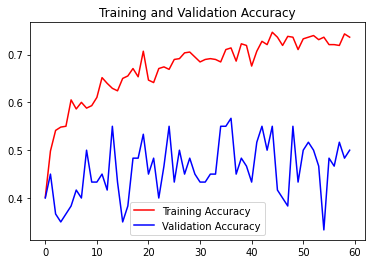

<Figure size 432x288 with 0 Axes>

In [ ]:
# 1
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()